In [619]:
import pandas as pd
import matplotlib.pyplot as plt

In [620]:
df = pd.read_parquet('resources/extended_dataset.parquet').set_index('Inspection ID')
df.head(2)

,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,...,Re-inspection,Community,Neighborhood,Ward,Precinct,Violation IDs,Nb Violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity
Inspection ID,,,,,,,,,,,,,,,,,,,,,
2320519,SALAM RESTAURANT,SALAM RESTAURANT,2002822,Restaurant,High,4634-4636 N KEDZIE AVE,60625,2019-10-25,Complaint,Pass,...,True,ALBANY PARK,"NORTH PARK,ALBANY PARK",33,27,[None],0,0,0,0
2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,Fail,...,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38,"[3, 5, 25, 50, 53, 53, 56, 58]",8,2,1,5


In [621]:
df['Inspection Type'].unique()

array(['Complaint', 'License', 'Canvass', 'Others',
       'Suspect food poisoning', 'Cancelled', 'Consultation', 'Unknown',
       'Task-force'], dtype=object)

In [622]:
df['Facility Type'].unique()

array(['Restaurant', 'Childrens services facility', 'Daycare (2-6 yo)',
       'Grocery store', 'Daycare (0-6 yo)', 'Liquor store', 'Caterer',
       'Mobile food dispenser', 'Sweetshop', 'Bakery', 'Tavern',
       'Long term care center', 'Unknown', 'Others', 'School',
       'Banquet hall', 'Golden Dinner', 'Hospital', 'Daycare (0-2 yo)',
       'Daycare (others)', 'Gas station', 'Wholesaler', 'Shared kitchen',
       'Rooftop', 'Coffee shop', 'Shelter'], dtype=object)

In [623]:
df['Results'] = df['Results'].map(lambda x: x if x != 'Pass w/ Conditions' else 'Pass')
df['Results'].unique()

array(['Pass', 'Fail', 'Not Ready', 'No Entry', 'Out of Business',
       'Business Not Located'], dtype=object)

In [624]:
facility_types_to_keep = ['Restaurant', 'Coffe shop', 'Tavern', 'Rooftop']
results_to_keep = ['Fail', 'Pass']
old_len = len(df)
df = df.dropna(subset=['AKA Name'])
df = df[df['Re-inspection'] == False]
df = df[df['Facility Type'].map(lambda x: x in facility_types_to_keep)]
df = df[df['Results'].map(lambda x: x in results_to_keep)]
df = df[df['Inspection Type'] != 'Cancelled']
print('We have thrown away {}% of the inspections'.format((1 - len(df)/old_len) * 100))

We have thrown away 54.067467040614716% of the inspections


In [625]:
def remove_special_chars(string):
    return ''.join(e for e in string if e.isalnum()).upper()

def standardize_names(string):
    if 'MCDONALDS' in string:
        return 'MCDONALDS'
    elif 'SUBWAY' in string:
        return 'SUBWAY'
    elif 'POTBELLYSANDWICH' in string:
        return 'POTBELLYSANDWICH'
    elif 'POPEYES' in string:
        return 'POPEYES'
    elif 'DUNKINDONUTS' in string:
        return 'DUNKINDONUTS'
    elif 'BURGERKING' in string:
        return 'BURGERKING'
    elif 'WENDYS' in string:
        return 'WENDYS'
    elif 'STARBUCKS' in string:
        return 'STARBUCKS'
    elif 'PIZZAHUT' in string:
        return 'PIZZAHUT'
    elif 'KFC' in string or 'KENTUCKYFRIEDCHICKEN' in string:
        return 'KFC'
    elif 'HAROLDSCHICKEN' in string:
        return 'HAROLDSCHICKEN'
    elif '7ELEVEN' in string:
        return '7ELEVEN'
    elif 'JJFISH' in string:
        return 'JJFISH'
    return string

In [626]:
df['AKA Name'] = df['AKA Name'].map(lambda x: standardize_names(remove_special_chars(x)) if x is not None else None)

In [627]:
nb_locations_by_aka_dict = {}
for name in df['AKA Name'].unique():
    nb_uniques = len(df[df['AKA Name'] == name].groupby('Address'))
    nb_locations_by_aka_dict[name] = nb_uniques

In [628]:
nb_locations_by_aka = pd.DataFrame(nb_locations_by_aka_dict.items(), columns=['AKA Name', 'Nb Addresses']).set_index('AKA Name').sort_values('Nb Addresses', ascending=False)
nb_locations_by_aka.head(10)

,Nb Addresses
AKA Name,
SUBWAY,296
DUNKINDONUTS,228
STARBUCKS,184
MCDONALDS,122
BURGERKING,58
HAROLDSCHICKEN,50
POTBELLYSANDWICH,48
POPEYES,42
JIMMYJOHNS,42


In [629]:
old_len = len(df)
df = df[df['AKA Name'].map(lambda x: nb_locations_by_aka.loc[x]['Nb Addresses'] >= 2)]
print('We have, once more, thrown away {}% of the inspections'.format((1 - len(df)/old_len) * 100))

We have, once more, thrown away 66.83161012813383% of the inspections


In [630]:
nb_inspections_by_aka = df[['AKA Name', 'DBA Name']].groupby('AKA Name').count().rename(columns={'DBA Name' : 'Nb Inspections'}).sort_values('Nb Inspections', ascending=False)
nb_passed_inspections_by_aka = df[df['Results'] == 'Pass'][['AKA Name', 'Results']].groupby('AKA Name').count().rename(columns={'Results' : 'Nb Passed Inspections'})
nb_failed_inspections_by_aka = df[df['Results'] == 'Fail'][['AKA Name', 'Results']].groupby('AKA Name').count().rename(columns={'Results' : 'Nb Failed Inspections'})
mean_nb_violations_by_aka = df[['AKA Name', 'Nb Violations']].groupby('AKA Name').mean().rename(columns={'Nb Violations' : 'Mean Nb Violations'})

In [631]:
df_joined = nb_inspections_by_aka.join(nb_locations_by_aka).join(nb_passed_inspections_by_aka.join(nb_failed_inspections_by_aka)).join(mean_nb_violations_by_aka)
df_joined['Mean Nb Inspections'] = df_joined['Nb Inspections'] / df_joined['Nb Addresses']
df_joined['Mean Percent Passed Inspections'] = (df_joined['Nb Passed Inspections'] / df_joined['Nb Addresses']) / df_joined['Mean Nb Inspections'] * 100
df_joined['Mean Percent Failed Inspections'] = 100 - df_joined['Mean Percent Passed Inspections']
df_joined = df_joined.drop(['Nb Passed Inspections', 'Nb Failed Inspections'], axis=1)

def size_category(nb_addresses):
    if nb_addresses >= 20:
        return 'Big'
    elif nb_addresses >= 5:
        return 'Medium'
    else:
        return 'Small'
    
df_joined['Size'] = df_joined['Nb Addresses'].map(size_category)

df_joined.head(10)

,Nb Inspections,Nb Addresses,Mean Nb Violations,Mean Nb Inspections,Mean Percent Passed Inspections,Mean Percent Failed Inspections,Size
AKA Name,,,,,,,
SUBWAY,3239,296,2.931460,10.942568,83.976536,16.023464,Big
DUNKINDONUTS,1831,228,3.416712,8.030702,80.939377,19.060623,Big
MCDONALDS,1606,122,3.415940,13.163934,78.767123,21.232877,Big
STARBUCKS,1107,184,2.368564,6.016304,85.275519,14.724481,Big
BURGERKING,545,58,3.823853,9.396552,79.816514,20.183486,Big
POPEYES,522,42,3.929119,12.428571,79.501916,20.498084,Big
POTBELLYSANDWICH,475,48,3.568421,9.895833,79.789474,20.210526,Big
KFC,389,36,3.976864,10.805556,78.663239,21.336761,Big
CHIPOTLEMEXICANGRILL,359,25,2.484680,14.360000,84.122563,15.877437,Big


## What is the distribution of the size categories ? ##

,Dist Size
Size,
Big,19
Medium,95
Small,923


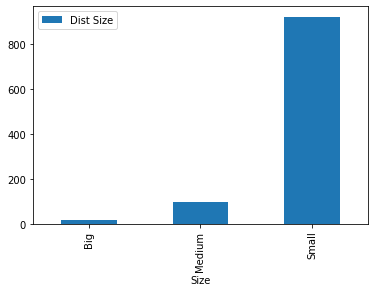

In [632]:
df_sizes = df_joined[['Size', 'Nb Inspections']].groupby('Size').count().rename(columns={'Nb Inspections' : 'Dist Size'})
df_sizes.plot.bar()
df_sizes

In [633]:
df_joined.groupby('Size').mean()

,Nb Inspections,Nb Addresses,Mean Nb Violations,Mean Nb Inspections,Mean Percent Passed Inspections,Mean Percent Failed Inspections
Size,,,,,,
Big,650.421053,70.947368,3.380073,8.894215,80.295838,19.704162
Medium,48.263158,7.200000,3.561780,6.581593,77.963048,22.036952
Small,13.306609,2.302275,4.284058,5.725984,74.381442,25.618558


## Which ones have more addresses ? ##

In [634]:
df_joined.sort_values('Nb Addresses', ascending=False).head(15)

,Nb Inspections,Nb Addresses,Mean Nb Violations,Mean Nb Inspections,Mean Percent Passed Inspections,Mean Percent Failed Inspections,Size
AKA Name,,,,,,,
SUBWAY,3239,296,2.931460,10.942568,83.976536,16.023464,Big
DUNKINDONUTS,1831,228,3.416712,8.030702,80.939377,19.060623,Big
STARBUCKS,1107,184,2.368564,6.016304,85.275519,14.724481,Big
MCDONALDS,1606,122,3.415940,13.163934,78.767123,21.232877,Big
BURGERKING,545,58,3.823853,9.396552,79.816514,20.183486,Big
HAROLDSCHICKEN,344,50,4.412791,6.880000,67.441860,32.558140,Big
POTBELLYSANDWICH,475,48,3.568421,9.895833,79.789474,20.210526,Big
POPEYES,522,42,3.929119,12.428571,79.501916,20.498084,Big
JIMMYJOHNS,341,42,2.806452,8.119048,82.111437,17.888563,Big


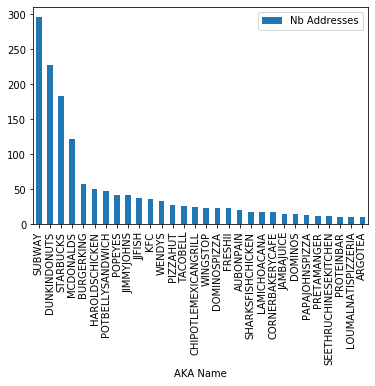

In [635]:
df_joined[['Nb Addresses']].sort_values('Nb Addresses', ascending=False).head(30).plot.bar()

## Which ones have more inspections in general ? ##

In [636]:
df_joined.sort_values('Mean Nb Inspections', ascending=False).head(15)

,Nb Inspections,Nb Addresses,Mean Nb Violations,Mean Nb Inspections,Mean Percent Passed Inspections,Mean Percent Failed Inspections,Size
AKA Name,,,,,,,
BJSMARKETBAKERY,45,2,5.555556,22.500000,73.333333,26.666667,Small
SEETHRUCHINESERESTAURANT,42,2,4.595238,21.000000,69.047619,30.952381,Small
GOLDCOASTDOGS,35,2,2.914286,17.500000,91.428571,8.571429,Small
PORTILLOSHOTDOGS,35,2,3.028571,17.500000,80.000000,20.000000,Small
GOLDENNUGGETPANCAKEHOUSE,34,2,4.000000,17.000000,91.176471,8.823529,Small
NUEVOLEONRESTAURANT,33,2,7.242424,16.500000,60.606061,39.393939,Small
WHALEFISHANDCHICKEN,32,2,3.406250,16.000000,81.250000,18.750000,Small
MAXWELLSTREETGRILL,31,2,3.290323,15.500000,90.322581,9.677419,Small
BAKERSSQUARE,46,3,5.717391,15.333333,67.391304,32.608696,Small


([], <a list of 0 Text xticklabel objects>)

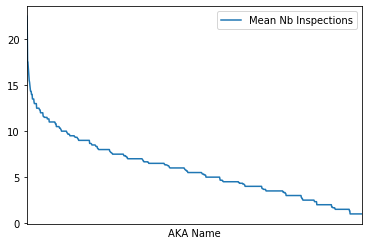

In [637]:
df_joined[['Mean Nb Inspections']].sort_values('Mean Nb Inspections', ascending=False).plot()
plt.xticks([])

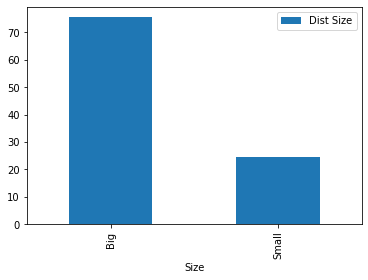

In [638]:
dist = df_joined.sort_values('Mean Nb Inspections', ascending=False).head(50)[['Size', 'Nb Inspections']].groupby('Size').count().rename(columns={'Nb Inspections' : 'Dist Size'})
dist['Dist Size'] = (dist['Dist Size'] / df_sizes['Dist Size'])
dist['Dist Size'] = dist['Dist Size'] / dist['Dist Size'].sum() * 100
dist.plot.bar()

## Which ones tend to easily pass inspections ? ##

In [639]:
df_joined.sort_values('Mean Percent Passed Inspections', ascending=False).head(15)

,Nb Inspections,Nb Addresses,Mean Nb Violations,Mean Nb Inspections,Mean Percent Passed Inspections,Mean Percent Failed Inspections,Size
AKA Name,,,,,,,
NARYSGRILLPIZZAINC,2,2,4.500000,1.0,100.0,0.0,Small
HIVIBE,9,3,1.666667,3.0,100.0,0.0,Small
MISTAPIZZA,9,2,2.666667,4.5,100.0,0.0,Small
MIKKEYSRETROGRILL,9,2,5.888889,4.5,100.0,0.0,Small
DJSUB,8,2,3.875000,4.0,100.0,0.0,Small
CHILL,8,2,4.625000,4.0,100.0,0.0,Small
WARMBELLYBAKERY,8,2,3.000000,4.0,100.0,0.0,Small
MOXEE,7,2,3.857143,3.5,100.0,0.0,Small
BONCI,7,2,2.428571,3.5,100.0,0.0,Small


([], <a list of 0 Text xticklabel objects>)

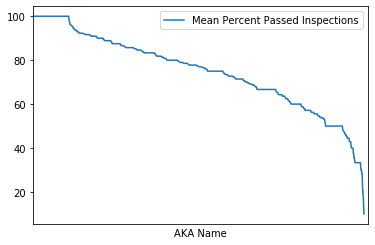

In [640]:
df_joined[['Mean Percent Passed Inspections']].sort_values('Mean Percent Passed Inspections', ascending=False).plot()
plt.xticks([])

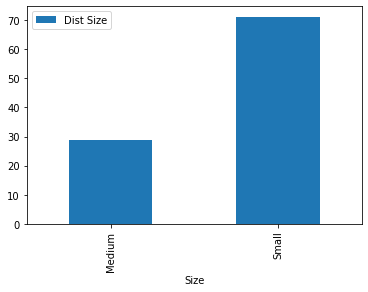

In [641]:
dist = df_joined.sort_values('Mean Percent Passed Inspections', ascending=False).head(50)[['Size', 'Nb Inspections']].groupby('Size').count().rename(columns={'Nb Inspections' : 'Dist Size'})
dist['Dist Size'] = (dist['Dist Size'] / df_sizes['Dist Size'])
dist['Dist Size'] = dist['Dist Size'] / dist['Dist Size'].sum() * 100
dist.plot.bar()

## Which ones tend to fail inspections ? ##

In [642]:
df_joined.sort_values('Mean Percent Failed Inspections', ascending=False).head(15)

,Nb Inspections,Nb Addresses,Mean Nb Violations,Mean Nb Inspections,Mean Percent Passed Inspections,Mean Percent Failed Inspections,Size
AKA Name,,,,,,,
VERAS,10,2,3.300000,5.000000,10.000000,90.000000,Small
CHINESELANTERN,7,2,6.714286,3.500000,14.285714,85.714286,Small
EDENSHOUSE,6,3,2.500000,2.000000,16.666667,83.333333,Small
79THSTREETBARBEQUE,5,2,4.200000,2.500000,20.000000,80.000000,Small
LEARNCHARTERSCHOOL,5,3,3.000000,1.666667,20.000000,80.000000,Small
CINNAMONCAFE,4,2,5.000000,2.000000,25.000000,75.000000,Small
CHICAGOWINGZAROUNDTHEWORLD,7,4,5.428571,1.750000,28.571429,71.428571,Small
ASIANTOWNNOODLES,7,2,5.428571,3.500000,28.571429,71.428571,Small
HAKKABAKKA,10,2,7.800000,5.000000,30.000000,70.000000,Small


([], <a list of 0 Text xticklabel objects>)

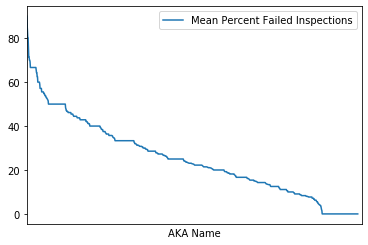

In [643]:
df_joined[['Mean Percent Failed Inspections']].sort_values('Mean Percent Failed Inspections', ascending=False).plot()
plt.xticks([])

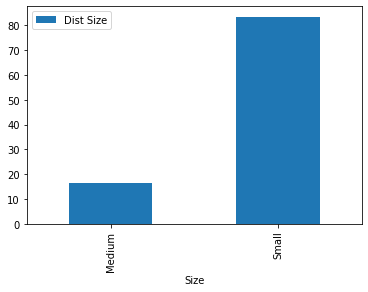

In [644]:
dist = df_joined.sort_values('Mean Percent Failed Inspections', ascending=False).head(50)[['Size', 'Nb Inspections']].groupby('Size').count().rename(columns={'Nb Inspections' : 'Dist Size'})
dist['Dist Size'] = (dist['Dist Size'] / df_sizes['Dist Size'])
dist['Dist Size'] = dist['Dist Size'] / dist['Dist Size'].sum() * 100
dist.plot.bar()

## Which ones have more violations by inspections ? ##

In [645]:
df_joined.sort_values('Mean Nb Violations', ascending=False).head(15)

,Nb Inspections,Nb Addresses,Mean Nb Violations,Mean Nb Inspections,Mean Percent Passed Inspections,Mean Percent Failed Inspections,Size
AKA Name,,,,,,,
THEGAME,3,2,12.333333,1.500000,33.333333,66.666667,Small
MSBSKITCHENCATERING,2,2,10.000000,1.000000,50.000000,50.000000,Small
RENALDISPIZZA,14,2,9.500000,7.000000,42.857143,57.142857,Small
JERKTACOMAN,20,3,9.300000,6.666667,45.000000,55.000000,Small
BABASHALAL,2,2,9.000000,1.000000,50.000000,50.000000,Small
KHANBBQRESTAURANT,17,2,8.882353,8.500000,58.823529,41.176471,Small
POMPEI,7,2,8.857143,3.500000,NaN,NaN,Small
CORNERSTONECAFE,16,2,8.625000,8.000000,62.500000,37.500000,Small
KINGPHOPLUS,5,2,8.600000,2.500000,40.000000,60.000000,Small


([], <a list of 0 Text xticklabel objects>)

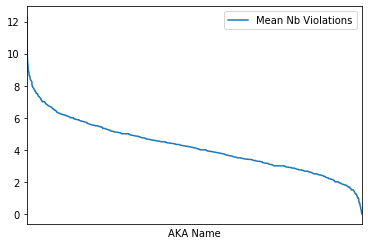

In [646]:
df_joined[['Mean Nb Violations']].sort_values('Mean Nb Violations', ascending=False).plot()
plt.xticks([])

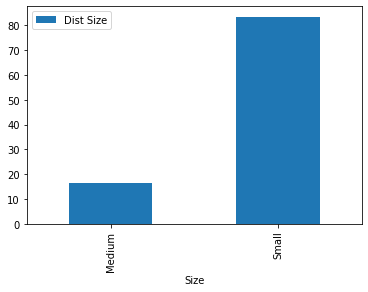

In [647]:
dist = df_joined.sort_values('Mean Nb Violations', ascending=False).head(50)[['Size', 'Nb Inspections']].groupby('Size').count().rename(columns={'Nb Inspections' : 'Dist Size'})
dist['Dist Size'] = (dist['Dist Size'] / df_sizes['Dist Size'])
dist['Dist Size'] = dist['Dist Size'] / dist['Dist Size'].sum() * 100
dist.plot.bar()